<h1 style='font-size:40px'> Classification</h1>
<h2 style='font-size:30px'> Apresentação do dataset</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Neste capítulo, lidaremos com dataset MNIST, que contém 70 mil imagens de algarismos escritos à mão por estudantes do Ensino Médio americano e empregados do escritório de censos dos EUA.
        </li>
    </ul>
</div>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [2]:
# Extraindo os dados de treino e teste. Cada coluna de 'X' é a intensidade do pixel da foto do dígito. 
# Como as imagens são 28x28, temos um total de 784 pixels e colunas.
X = mnist.data
y = mnist.target.astype(int)

<h3 style='font-size:30px;font-style:italic'> Conhecendo os dados</h3>

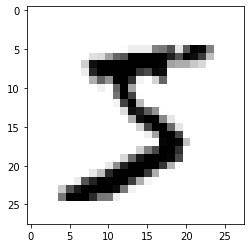

In [3]:
# Vamos analisar a imagem de um dos dígitos do dataset utilizando o matplotlib.
import matplotlib.pyplot as plt
from matplotlib.cm import binary
import numpy as np

# Obtendo os pixels do primeiro número do dataset.
some_digit_image = X.iloc[0].values.reshape(28,28)

# Tudo indica que se trata de um cinco.
plt.imshow(some_digit_image, cmap=binary, interpolation='nearest')

In [4]:
# E, de fato, o dígito em questão é um 5.
y[0]

5

<h3 style='font-size:30px;font-style:italic'> Segregação de dados</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            Os dados de <em>mnist</em> já estão ordenados de maneira que as 60 mil primeiras ocorrências sejam destinadas a treino e as outras 10 mil instâncias para teste.
        </li>
    </ul>
</div>

In [5]:
# Um unpacking de tuplas será o suficiente para essa operação.
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

<h2 style='font-size:30px'> Training a Binary Classifier</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Vamos começar o capítulo com uma tarefa simples: criar um classificador que identifique quando a imagem se refere a um número definido x, e quando ela não representa X. Neste caso, estamos diante de um trabalho de classificação binária.
        </li>
    </ul>
</div>

In [6]:
# O autor escolheu identificar as ocorrências de 5 e não-5.

# Os novos datasets terão valores booleanos. True para 5 e False para não-5
y_train_5 = y_train == 5
y_test_5 = y_test == 5

<div>
    <ul style='font-size:20px'>
        <li>
            Para começar a nossa tarefa, vamos utilizar o Stochastic Gradient Descent (SGD), do módulo sklearn.linear_model. Ele é bastante eficaz em lidar com datasets grandes.
        </li>
    </ul>
</div>

In [7]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Prevendo o valor da primeira instância de X (5). O classificador adivinha com sucesso.
sgd_clf.predict(X.iloc[0].values.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

<h2 style='font-size:30px'> Performance Measures</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Aqui, o autor faz uma breve demosntração sobre como a acurácia pode não ser a métrica de qualidade mais adequada com datasets desbalanceados.
        </li>
    </ul>
</div>

In [8]:
# Realizando uma validação cruzada cuja métrica de performance é o score do modelo. 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5,cv=3, scoring='accuracy').mean()

0.9570333333333334

In [9]:
# Agora, vamos criar um Dummy Classifier caseiro com a classe pré-definida BaseEstimator.
# Ele sempre previrá que o número não é 5.
from sklearn.base import BaseEstimator
import numpy as np
class Never5Classifier(BaseEstimator):
    # Algo que eu havia esquecido sobre POO, podemos fazer uma classe sem um __init__.
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype='bool' )


In [10]:
# Agora, vamos fazer uma validação cruzada com esse classificador 'burro'
never_5_clf = Never5Classifier()

# Veja, mesmo sendo dogmático, Never5Classifier tem uma taxa de acerto de quase 91%.
cross_val_score(never_5_clf, X_train, y_train_5, cv=3 ,scoring='accuracy').mean()

0.90965

<h3 style='font-size:30px;font-style:italic'> Confusion Matrix</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            A matriz de confusão é uma represetação visual que contabiliza o número de classificações (certas ou erradas) feitas pelo modelo. Como apontado pelo autor, se quiséssemos saber quantas vezes o algoritmo confundiu 5 com 3, basta olharmos a terceira coluna da quinta linha da matriz. 
        </li>
    </ul>
</div>

In [11]:
# Prevendo os valores-alvo do dataset de treino com cross_val_predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)

In [12]:
# As linhas representam a classe verdadeira; já as colunas, a classe prevista pelo modelo.

# Nesse caso, temos mais de 50 mil valores não-5 previstos como não-5 e 3530 5's rotulados como 5.
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

<AxesSubplot:>

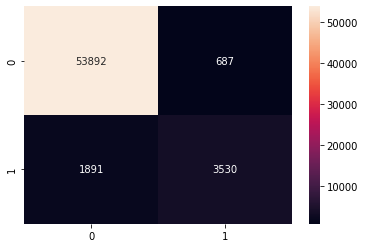

In [13]:
# Podemos utilizar um mapa de calor do seaborn para melhorar a visualização dos dados.
import seaborn as sns
sns.heatmap(confusion_matrix(y_train_5, y_train_pred), annot=True, fmt='.5g')

<div>
    <ul style='font-size:20px'>
        <li>
            A partir da matriz de confusão, podemos estimar novas métricas qualitativas sobre o modelo. Por exemplo, entre as instâncias classificadas como positivas (1), qual a porcentagem delas é realmente positiva (Precision)? Ou, de todas as instâncias positivas do dataset, qual a porcentagem delas foi que o modelo conseguiu rotular como tal (Recall)? 
        </li>
    </ul>
</div>
<center> 
    <img src='precision_recall1.png'>
</center>

<h3 style='font-size:30px;font-style:italic'> Precision and Recall</h3>

In [14]:
# Medindo as novas métricas aprendidas com o sklearn.metrics
from sklearn.metrics import recall_score, precision_score
print(f'Precisão do modelo: {precision_score(y_train_5,y_train_pred) :.2%}')
print(f'Recall do modelo: {recall_score(y_train_5,y_train_pred) :.2%}')

Precisão do modelo: 83.71%
Recall do modelo: 65.12%


<h3 style='font-size:30px;font-style:italic'> F1-Score</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            O F1-Score é a média harmônica entre precision e recall. Diferentemente de uma média comum, esse índice dá um peso maior a valores pequenos.
        </li>
    </ul>
</div>

In [15]:
from sklearn.metrics import f1_score
print(f'F1-Score do modelo: {f1_score(y_train_5,y_train_pred) :.2%}')

F1-Score do modelo: 73.25%


<h3 style='font-size:30px;font-style:italic'> Precision/Recall Tradeoff</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            Neste tópico, o autor discorre sobre a inevitável correlação negativa entre precision e recall. Quando queremos aumentar o valor de um dos índices, teremos que sacrificar parte do desempenho do outro.
        </li>
        <li>
            Para ilustrar como isso ocorre, é apresentada a função de pontuação da chamada <em>decision_function</em>. Os modelos de classificação aplicam essa função para cada instância a ser rotulada, o que se resulta em um número. Esse valor pode ser maior ou menor do que o threshold escolhido. Caso seja mais alto, a instância será agrupada na classe positiva; caso o contrário, na classe negativa.  
        </li>
        <li>
            O scikit-learn não nos permite ajustar esse threshold ao criarmos o modelo, mas podemos ajustá-lo, manualmente, com uma simples expressão comparativa. 
        </li>
    </ul>
</div>

In [16]:
# Ao invés de invocarmos 'predict', chamaremos o método 'decision_function' ao SGDClassifier.
# Qual é o valor da função de decisão na nossa instância 'some_digit_image'?
y_scores = sgd_clf.decision_function(some_digit_image.reshape(1,-1))
y_scores

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [17]:
# Definindo o threshold como 0, como o classificador rotulará a instância?
thresold = 0
y_some_digit_pred = y_scores > thresold
y_some_digit_pred

array([ True])

In [18]:
# Agora, o thresolhd será elevado a 8000. Como sera a previsão?
thresold = 8000
y_some_digit_pred = y_scores > thresold
y_some_digit_pred

array([False])

<div> 
    <ul style='font-size:20px'> 
        <li>
            Isso constata que, aumentar o thresolhd diminui o recall do modelo.
        </li>
    </ul>
</div>

In [19]:
# O 'cross_val_predict' é capaz de nos retornar a pontuação da decision function do modelo.
# Basta definirmos  'method' como 'decision_function'.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [20]:
# O scikit-learn tem um método capaz de nos mostrar as variações de precision de acordo com o thresolhd visualmente.
from sklearn.metrics import precision_recall_curve

# A função nos retorna os índices e seus respectivos thresholds.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

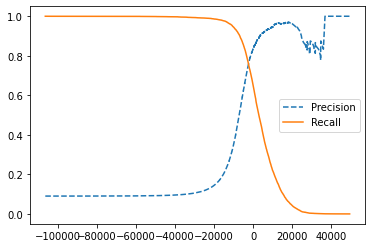

In [21]:
import matplotlib.pyplot as plt
# É comum a curva de precision sofrer pequenas quedas enquanto o threshold aumenta.
plt.plot(thresholds, precisions[:-1], linestyle='--', label='Precision')
plt.plot(thresholds, recalls[:-1], linestyle='-', label='Recall')
plt.legend()

Text(0, 0.5, 'Precision')

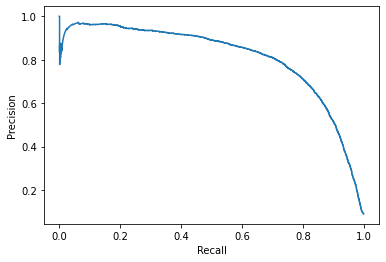

In [22]:
# Outra maneira de se plotar os dados, só que sem os thresholds.
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [23]:
# Supondo que quiséssemos ter no mínimo 90% de precisão. Qual threshold escolher?

# np.argmax retorna o primeiro índice do valor máximo (como a condição passada entre parênteses é booleana,
# o índice será o do primeiro True que aparecer)

# Ok, o primeiro threshold que nos dará mais de 90% de precisão está na posição 57075 de 'thresolhds'.
print(np.argmax(precisions>=0.9))

threshold_90_precision = thresholds[np.argmax(precisions>0.9)]
threshold_90_precision

57075


3370.019499143957

In [24]:
# Agora, fazendo previsões usando o threshold escolhido.
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [25]:
# Por questões de verificação, calculando a precision e recall dessas previsões.
print(f'Precisão: {precision_score(y_train_5, y_train_pred_90) :.2%}')
print(f'Recall: {recall_score(y_train_5, y_train_pred_90) :.2%}')

Precisão: 90.00%
Recall: 48.00%


<div> 
    <ul style='font-size:20px'> 
        <li>
            O autor nos adverte que, no entanto, não é recomendável priorizarmos precision em  prejuízo a recall. 
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> The ROC Curve</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>
             A curva ROC mostra a relação entre a taxa de positivos verdadeiros (aka. recall) versus a taxa de falsos positivos.
        </li>
        <li>
            A taxa de falsos positivos pode ser entendida também como 1 - (taxa de negativos verdadeiros (aka. specificity))
        </li>
    </ul>
</div>

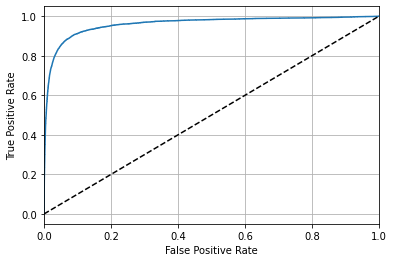

In [26]:
# Novamente, o sklearn.metrics tem uma função pronta para plotagem de ROC Curves.
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

<div> 
    <ul style='font-size:20px'> 
        <li>
            A linha tracejada indica as taxas obtidas por um classificador meramente aleatório.
        </li>
        <li>
            O ideal para os classificadores binários é que a área sob a ROC Curve fique o mais próxima o possível de 1.
        </li>
    </ul>
</div>

In [27]:
# Coumputando a area under the curve de nosso modelo.
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<div> 
    <ul style='font-size:20px'> 
        <li>
            O autor recomenda que a PR Curve seja utilizada apenas com datasets com poucas classes positivas; ou quando nos importamos mais com falsos positivos do que com falsos negativos. Caso o contrário, use ROC Curve.
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> Teste com o RandomForest</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>
             O autor tentará comparar a ROC Curve e a AUC de uma Random Forest com as já mensuradas. 
        </li>
        <li>
            No entanto, o RandomForestClassifier não tem decision_function imbutida. Ao invés disso, ele nos retorna as probabilidades de classe em um array. Para cada instância, uma linha com as probabilidades de classe aparecem.
        </li>
    </ul>
</div>

In [28]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

# Como já dito, o array retornado nos dá uma coluna para cada classe. No entanto, 'roc_curve' admite um array unidimensional apenas.
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [29]:
# Considerando isso, vamos selecionar apenas as probabilidades de classe positiva.
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

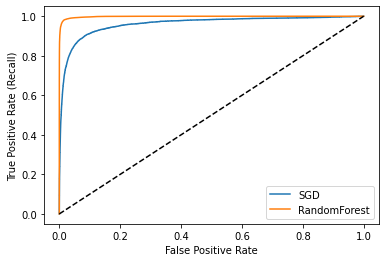

In [30]:
# Com isso, estamos prontos para fazermos a comparação.
plt.plot(fpr, tpr, label='SGD')
plt.plot(fpr_forest, tpr_forest, label='RandomForest')
plt.plot([0,1], [0,1], linestyle='--', color='k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
# Visivelmente, a Random Forest tem um auc_score maior.
plt.legend()

In [31]:
# AUC Scores do modelo.
print(f'AUC Score SGD: {roc_auc_score(y_train_5, y_scores)}')
print(f'AUC Score Random Forest: {roc_auc_score(y_train_5, y_scores_forest)}')

AUC Score SGD: 0.9604938554008616
AUC Score Random Forest: 0.9983436731328145


In [32]:
# A fim de termos uma avaliação completa da Random Forest, vamos calcular sua precision e recall.

# Lembre-se, essa métricas são calculadas com base nas previsões reais do modelo, e não em suas 'decision_function''s ou 'predict_proba''s.
forest_predict = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict')
forest_precision = precision_score(y_train_5, forest_predict)
forest_recall = recall_score(y_train_5, forest_predict)

In [33]:
# A Random Forest novamente bate o SGDClassifier.
print(f'Precisão Random Forest: {forest_precision}')
print(f'Recall Random Forest: {forest_recall}')

Precisão Random Forest: 0.9905083315756169
Recall Random Forest: 0.8662608374838591


<h2 style='font-size:30px'> Multiclass Classification</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Com relação às multiplas classificações, existem algoritmos capazes de lidar com várias categorias diretamente (como o Naive Bayes ou o próprio Random Forest). Por outro lado, alguns outros são construídos para apenas serem usados em situações de classificação binária (como o SVM e classificadores Lineares).
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> One versus All (OvA)</h3>
<div> 
    <ul style='font-size:20px'> 
        <li>
            Apesar disso, ainda conseguimos usar classificadores binários em situações de classificações múltiplas. Na estratégia <em>One versus All</em>, para cada categoria, é criado um classificador responsável por identificar dados que são pertencentes ou não a ela (ex: 5's e não-5's; 3's e não-3's). Quando esses modelos confrontarem uma instância nunca vista, aquele com a maior pontuação de decision_function é o que a rotulará com a sua respectiva categoria. Ou seja, se o classificador de 5's tiver o maior valor, a instância será rotulada como 5.
        </li>
        <li>
            A desvantagem dessa abordagem é que cada classificador será alimentado com uma cópia completa do dataset de treino. Para modelos como o SVM, isso pode gerar fases de treino muito lentas.
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> One versus One (OvO)</h3>
<div> 
    <ul style='font-size:20px'>
        <li>
            A abordagem One vs One cria um classificador binário para cada par de categoria existente. No contexto de nosso dataset, haverá um modelo de previsão de 1's ou 2', de 4 ou 6', e assim por diante. Quando uma instância for classificada, a categoria que lhe for mais atribuída será o seu rótulo.
        </li>
        <li>
            Apesar de serem numericamente mais abundantes, os modelos precisarão apenas ser alimentados com a seção do dataset que lida com o seu par de categorias.
        </li>
    </ul>
</div>

In [34]:
# O scikit-learn é capaz de escolher quais dessas estratégias utilizar por conta própria. Com exceção das SVM, todos os modelos
# rodam com OvA.

# Usando o Stochastic Gradient Descent para fazer uma previsão múltipla. O que ele faz por baixo dos panos é criar um modelo
# para cada categoria existente em uma estratégia OvA. Aquele que retornar o maior número de 'decisio_function' rotulará a instância
# com sua respectiva classe.
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit_image.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3])

In [35]:
# Para comprovar que 10 SGD's foram rodados, vamos invocar 'decision_function'. Recebemos um array com 10 elementos.
print(sgd_clf.decision_function(some_digit_image.reshape(1,-1)))

# O método 'np.argmax' também nos indica qual rótulo foi conferido.
np.argmax(sgd_clf.decision_function(some_digit_image.reshape(1,-1)))

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


3

In [36]:
# O atributo 'classes_' nos mostra as categorias-alvo do dataset.
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

<h3 style='font-size:30px;font-style:italic'> sklearn.multiclass</h3>
<div> 
    <ul style='font-size:20px'>
        <li>
            Podemos configurar um classificador binário para fazer um OvA ou OvO com as classes OneVsOneClassifier e OneVsRestClassifier.
        </li>
    </ul>
</div>

In [37]:
# Fazendo um SGD OvO.
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

# Veja! Agora o modelo acertou a classe.
ovo_clf.predict(some_digit_image.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


array([5])

In [38]:
# Por ser OvO, 45 SGDClassifiers foram criados.
len(ovo_clf.estimators_)

45

<h3 style='font-size:30px;font-style:italic'> Modelos para múltiplas classificações</h3>
<div> 
    <ul style='font-size:20px'>
        <li>
            Como dito, o RandomForestClassifier admite fazer classificações com várias categorias.
        </li>
    </ul>
</div>

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.predict(some_digit_image.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([5])

In [40]:
# Um único RandomForest nos oferece todas as probabilidades de classificação.
forest_clf.predict_proba(some_digit_image.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.86, 0.  , 0.02, 0.03, 0.  ]])

<h2 style='font-size:30px'> Error Analysis</h2> 
<div> 
    <ul style='font-size:20px'> 
        <li>
            Esta seção é dedicada à análise das espécies de erro que nossos modelos podem fazer. Tal tarefa é bastante importante na tunagem de algoritmos.
        </li>
    </ul>
</div>

In [41]:
# As matrizes de confusão sã um instrumento adequado para esse procedimento.
from sklearn.preprocessing import StandardScaler

# Buscando melhora de performance, vamos colocar os valores independetes dentro de uma mesma escala.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

# Fazendo a matriz de confusão.
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

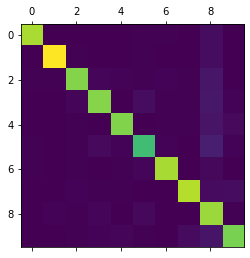

In [42]:
# O heatmap criado com o matplotlib já nos revela. O número total de 5's corretamente identificados é
# menor do que os demais.

# Isso pode se dar por duas razões. É capaz de haver, um menor número absoluto de 5's no dataset;
# ou o SGDClassifier está de fato pecando em identificá-los.
plt.matshow(conf_mx)

In [43]:
# O autor argumenta que, na verdade, ambos os problemas existem. Primeiramente, vamos tentar enxergar
# a taxa de erro na classificação de cada classe.

# Somando o número de instâncias de cada classe. 
# 'keepdims' preserva o caráter bidimensional da matriz.
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

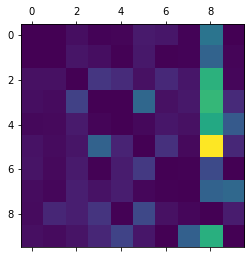

In [44]:
# Obtendo a porcentagem de erros.
norm_conf_mx = conf_mx / row_sums

# Preenchendo as diagonais da matriz com 0, de modo que possamos enxergar apenas os erros.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx )

<div> 
    <ul style='font-size:20px'> 
        <li>
            O algoritmo confunde bastante 5s com 8s. Para corrigir esse problema, o autor menciona uma série de estratégias, como editar as imagens usando bibliotecas como o Pillow ou OpenCV; ou criando uma coluna com o número de 'loops fechados' (8 tem dois, 6 tem um e 5 tem nenhum).
        </li>
        <li>
            Uma outra forma, mais demorada, seria analisarmos individualmente os erros cometidos.
        </li>
    </ul>
</div>

In [51]:
from matplotlib.cm import binary
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = binary, **options)
    plt.axis("off")

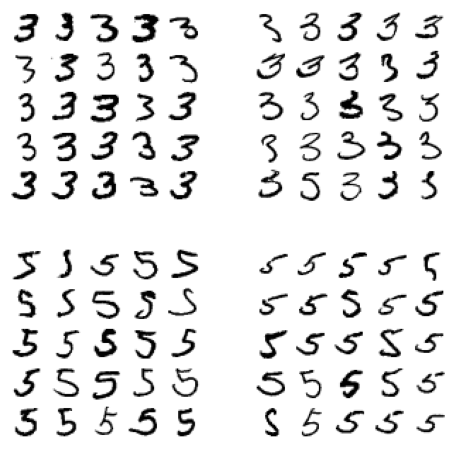

In [54]:
# Obtendo os casos em que 3s foram classificados como 3 ou 5s ou 5s como 5 ou 3.
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5)

<div> 
    <ul style='font-size:20px'> 
        <li> 
            A diagonal principal mostra as imagens devidamente classificadas (3 e 5, respectivamente); a complementar, os erros do modelo (seguindo a mesma ordem).
        </li>
        <li>
            Não podemos discordar que exisitem dígitos que realmente estão mal escritos. No entanto, o SGDClassifier ainda comete erros grosseiros; é necessário lembrar que se trata de um simples modelo linear. Talvez precisaríamos de algo mais sofisticado se quisermos obter diminuir esses defeitos.
        </li>
    </ul>
</div>

<h2 style='font-size:30px'> Multilabel Classification</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Muitas vezes, precisaremos construir modelos que nos retornem mais de um output binário. No contexto do reconhecimento de imagem, um algoritmo pode ser treinado para reconhecer se uma pessoa tem pele clara e cabelo loiro, por exemplo.
        </li>
        <li>
            Com isso, ao apresentar uma pessoa negra de cabelo castanho, o modelo deve retornar [0,0].
        </li>
    </ul>
</div>

In [57]:
from sklearn.neighbors import KNeighborsClassifier

# O KNN deve identificar se o número é grande (7,8 ou 9) e se ele é ímpar.
y_train_large = (y_train >=7)
y_train_odd = (y_train %2 == 1)

# Ambos os arrays de valores-alvo devem ser concatenados.
y_multiabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier().fit(X_train, y_multiabel)

# O previsor retornou que o nosso dígito (5) não é grande e que ele é ímpar. Perfeito!
knn_clf.predict(some_digit_image.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [62]:
# A avaliação dos modelos de multilabel classification é bastante simples.
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multiabel, cv=3)

# Tendo 'average' como marco, ambas as classes terão o mesmo peso no cálculo do f1_score.
print(f1_score(y_multiabel,y_train_knn_pred, average='macro'))

# Ao setarmos esse argumento como 'weighted', o label com maior presença no dataset terá um peso mais significativo.
# Por exemplo, se houver mais números ímpares do que 7,8 e 9s, a adivinhação daqueles impactará mais no f1_score.
print(f1_score(y_multiabel,y_train_knn_pred, average='weighted'))

0.976410265560605
0.9778357403921755


<h2 style='font-size:30px'>Multioutput Classification </h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            Consiste em fazer o seu modelo retornar mais de um output. No entanto, este não precisa ser binário.
        </li>
    </ul>
</div>

In [70]:
# Como exemplo, o autor sugere criar um limpador de imagens, que reduziria a intensidade de pixels que atrapalham, de alguma
# maneira, a visualização do dígito.
import numpy as np
# Isso se configura como uma Multioutput Classification pois os pixels modificados podem ter valores que vão de 0 a 255.

# Criando imagens borradas.
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train + noise

noise_ = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise_

# O output esperado são os valores verdadeiros das variáveis independentes (que produzam imagens sem borros). 
y_train_mod = X_train
y_test_mod = X_test

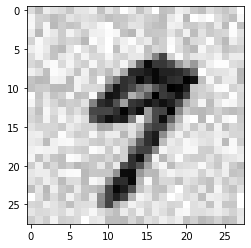

In [88]:
# Um exemplo de imagem borrada.
plt.imshow(X_test_mod.iloc[20].values.reshape(28,28), cmap=binary)

In [89]:
# Criando um KNN para a correção.
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test.iloc[20].values.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


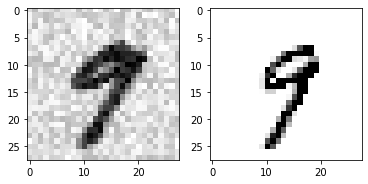

In [91]:
# Veja como ficou!
plt.subplot(121)
plt.imshow(X_test_mod.iloc[20].values.reshape(28,28), cmap=binary)
plt.subplot(122)
plt.imshow(clean_digit.reshape(28,28), cmap=binary)

<div> 
    <ul style='font-size:20px'> 
        <li> 
            Apesar de sua natureza parecer excêntrica, acabamos de ver como a Multioutput Classification é usada em tarefas cotidianas. É bem concebível criar um software de correção de imagens usando Machine Learning!
        </li>
    </ul>
</div>